In [5]:
from pyspark.sql import SparkSession
from pathlib import Path
import pyspark.sql.functions as func
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum


def read_parquet_file(spark, file_path):
    df = spark.read.parquet(file_path)
    return df


def is_hdfs_file_exist(path):
    proc = subprocess.Popen(['hadoop', 'fs', '-test', '-e', path])
    proc.communicate()
    return proc.returncode == 0


def add_index_to_dataframe(df):
    return df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))



spark = SparkSession.builder.appName('lr_example').getOrCreate()

# Load data
hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"
case_file_dest = "case_daily_summary.parquet"

all_data = read_parquet_file(spark, hdfs_host+hdfs_root_path+case_file_dest)
all_data.printSchema()



root
 |-- date: string (nullable = true)
 |-- dailyConfirmed: integer (nullable = true)



In [7]:
cases_group_by_date = all_data.withColumn("dayOfWeek", func.dayofweek(all_data["date"]))
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()
cases_group_by_date.printSchema()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-01-23|             1|        5|    1|
|2020-01-24|             2|        6|    2|
|2020-01-25|             1|        7|    3|
|2020-01-26|             0|        1|    4|
|2020-01-27|             1|        2|    5|
|2020-01-28|             2|        3|    6|
|2020-01-29|             3|        4|    7|
|2020-01-30|             3|        5|    8|
|2020-01-31|             3|        6|    9|
|2020-02-01|             2|        7|   10|
|2020-02-02|             0|        1|   11|
|2020-02-03|             0|        2|   12|
|2020-02-04|             6|        3|   13|
|2020-02-05|             4|        4|   14|
|2020-02-06|             2|        5|   15|
|2020-02-07|             3|        6|   16|
|2020-02-08|             7|        7|   17|
|2020-02-09|             3|        1|   18|
|2020-02-10|             2|        2|   19|
|2020-02-11|             2|     

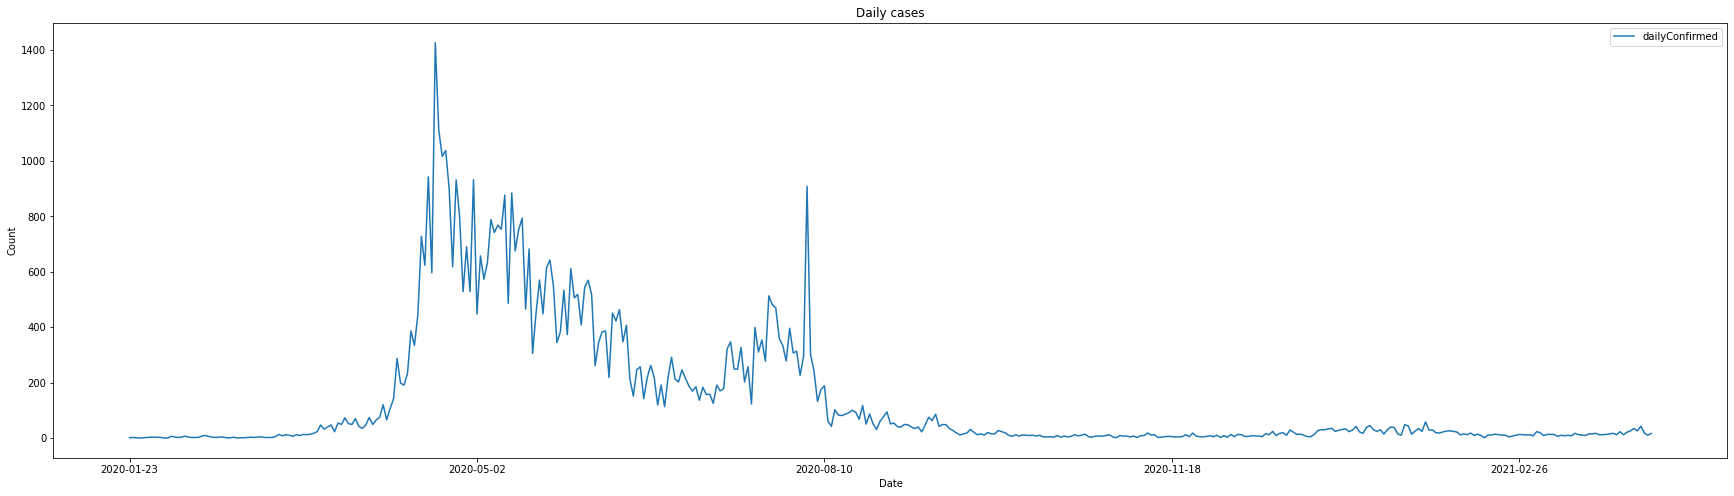

In [19]:
cases_group_by_date.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")
plt.rcParams["figure.figsize"] = (30,5)

+---------+-------------------+
|dayOfWeek|sum(dailyConfirmed)|
+---------+-------------------+
|        1|               8823|
|        2|               8083|
|        3|               8105|
|        4|               9512|
|        5|               8698|
|        6|               9152|
|        7|               8202|
+---------+-------------------+



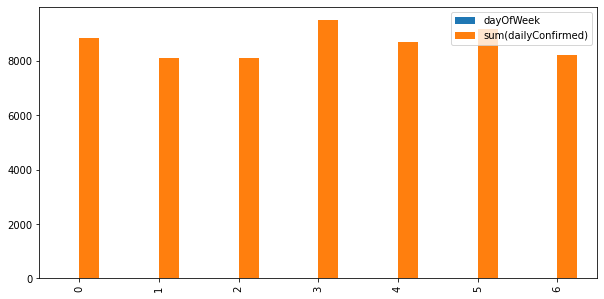

In [22]:

#cases_group_by_date.select("count").distinct().show()
cases_group_by_day_of_week = cases_group_by_date\
                        .groupby(['dayOfWeek'])\
                        .agg(_sum('dailyConfirmed'))\
                        .orderBy('dayOfWeek',asending=True)
cases_group_by_day_of_week.show()

cases_group_by_day_of_week.toPandas().plot(kind='bar')
plt.rcParams["figure.figsize"] = (5,5)

In [31]:
cases_group_by_date=cases_group_by_date.filter(cases_group_by_date["Date"]>='2020-09-15').drop("index")
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-09-15|            34|        3|    1|
|2020-09-16|            27|        4|    2|
|2020-09-17|            18|        5|    3|
|2020-09-18|            11|        6|    4|
|2020-09-19|            15|        7|    5|
|2020-09-20|            18|        1|    6|
|2020-09-21|            31|        2|    7|
|2020-09-22|            21|        3|    8|
|2020-09-23|            12|        4|    9|
|2020-09-24|            15|        5|   10|
|2020-09-25|            11|        6|   11|
|2020-09-26|            20|        7|   12|
|2020-09-27|            15|        1|   13|
|2020-09-28|            15|        2|   14|
|2020-09-29|            27|        3|   15|
|2020-09-30|            23|        4|   16|
|2020-10-01|            19|        5|   17|
|2020-10-02|            10|        6|   18|
|2020-10-03|             6|        7|   19|
|2020-10-04|            12|     

In [44]:
# Split into training data and test data
total_count = cases_group_by_date.count()
print(total_count)
seventy_percent_index = round(total_count * 0.5)
cases_group_by_date.registerTempTable("daily_cases")
train_data = spark.sql("select * from daily_cases where index <= {}".format(seventy_percent_index))
test_data = spark.sql("select * from daily_cases where index > {}".format(seventy_percent_index))
train_data.show()
test_data.show()

203
+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-09-15|            34|        3|    1|
|2020-09-16|            27|        4|    2|
|2020-09-17|            18|        5|    3|
|2020-09-18|            11|        6|    4|
|2020-09-19|            15|        7|    5|
|2020-09-20|            18|        1|    6|
|2020-09-21|            31|        2|    7|
|2020-09-22|            21|        3|    8|
|2020-09-23|            12|        4|    9|
|2020-09-24|            15|        5|   10|
|2020-09-25|            11|        6|   11|
|2020-09-26|            20|        7|   12|
|2020-09-27|            15|        1|   13|
|2020-09-28|            15|        2|   14|
|2020-09-29|            27|        3|   15|
|2020-09-30|            23|        4|   16|
|2020-10-01|            19|        5|   17|
|2020-10-02|            10|        6|   18|
|2020-10-03|             6|        7|   19|
|2020-10-04|            12| 

In [39]:
# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index"], outputCol="features")
train_sub = vectorAssembler.transform(train_data)
test_sub = vectorAssembler.transform(test_data)

lr = LinearRegression(featuresCol='features',labelCol='dailyConfirmed',predictionCol='prediction')
# Fit the model
lr_model = lr.fit(train_sub)
# Print the coefficients and intercept training data
print("Coefficients: {}".format(str(lr_model.coefficients)))
print("Intercept: {}".format(str(lr_model.intercept)))

Coefficients: [-0.05037574002974268]
Intercept: 12.957095709570966


Text(0, 0.5, 'Count')

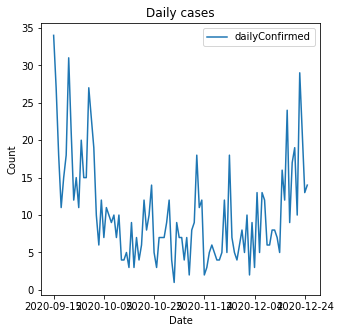

In [40]:
train_data.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

In [41]:
# Testing result
test_result = lr_model.evaluate(test_sub)
test_result.residuals.show()
print("RMSE: {}".format(test_result.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
| 2.2316055134925303|
|-2.7180187464777275|
|-2.6676430064479844|
|  5.382732733581758|
|   19.4331084736115|
| 22.483484213641244|
| 22.533859953670987|
| 25.584235693700727|
|  27.63461143373047|
| 16.684987173760213|
| 20.735362913789956|
|   23.7857386538197|
| 25.836114393849442|
| 15.886490133879185|
|  21.93686587390893|
|  34.98724161393867|
| 15.037617353968413|
| 10.087993093998156|
| 31.138368834027897|
| 38.188744574057644|
+-------------------+
only showing top 20 rows

RMSE: 17.89632891329284


In [42]:
# Prediction
predictions = lr_model.transform(test_sub)
predictions = predictions.withColumn("prediction",func.round(predictions["prediction"]))
predictions.show()


+----------+--------------+---------+-----+--------+----------+
|      date|dailyConfirmed|dayOfWeek|index|features|prediction|
+----------+--------------+---------+-----+--------+----------+
|2020-12-26|            10|        7|  103| [103.0]|       8.0|
|2020-12-27|             5|        1|  104| [104.0]|       8.0|
|2020-12-28|             5|        2|  105| [105.0]|       8.0|
|2020-12-29|            13|        3|  106| [106.0]|       8.0|
|2020-12-30|            27|        4|  107| [107.0]|       8.0|
|2020-12-31|            30|        5|  108| [108.0]|       8.0|
|2021-01-01|            30|        6|  109| [109.0]|       7.0|
|2021-01-02|            33|        7|  110| [110.0]|       7.0|
|2021-01-03|            35|        1|  111| [111.0]|       7.0|
|2021-01-04|            24|        2|  112| [112.0]|       7.0|
|2021-01-05|            28|        3|  113| [113.0]|       7.0|
|2021-01-06|            31|        4|  114| [114.0]|       7.0|
|2021-01-07|            33|        5|  1

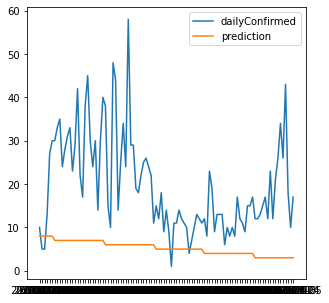

In [43]:
predictionsPandas = predictions.toPandas()

plt.plot( 'date', 'dailyConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction', data=predictionsPandas, marker='')

# show legend
plt.legend()
# show graph
plt.show()
